In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_ASSIGNMENTS= K
NUM_OBS = D + D*K + D*K
BATCH_SIZE = 10
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
covs = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    return B * (K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, torch.cat((stat1, stat2.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_ASSIGNMENTS):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        zs_pi = self.enc_onehot(obs).view(batch_size, N, K)
        zs = cat(zs_pi).sample((num_samples,))
        log_qz = cat(zs_pi).log_prob(zs).view(num_samples, batch_size, -1).sum(-1) ## S * B
        zs = zs.view(num_samples, batch_size, -1, K) ## S * B * N * K
        return zs_pi, zs, log_qz

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
def log_joints_gmm(Z, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size):
    log_probs = torch.zeros((num_samples, batch_size)).float()
#     ## S * B
#     log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1) ## S * B
    labels = Z.nonzero()
    log_probs = log_probs + Normal(mus[labels[:, 1], labels[:, -1], :].view(num_samples, batch_size, N, -1), covs[labels[:, 1], labels[:, -1], :].view(num_samples, batch_size, N, -1)).log_prob(Xs).sum(-1).sum(-1)
    return log_probs
    
def rws(Xs, Pi, mus, covs, N, K, D, num_samples, batch_size):

    mus_flat = mus.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    covs_flat = covs.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    
    data = torch.cat((Xs, mus_flat, covs_flat), -1).view(batch_size*N, -1)
    zs_pi, zs, log_qz = enc(data, N, K, D, num_samples, batch_size)
    log_p = log_joints_gmm(zs, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size)
    log_weights = log_p - log_qz
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    return eubo, elbo, ess

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [8]:
EUBOs = []
ELBOs = []
ESSs = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        batch_Covs = covs[batch_indices]
        batch_Mus = mus_true[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess = rws(batch_Xs, Pi, batch_Mus, batch_Covs, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()     
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    
#     time_end = time.time()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-933.409549, ELBO=-1296.421004, ESS=1.036 (2s)
epoch=10, EUBO=-602.515665, ELBO=-930.757537, ESS=1.025 (20s)
epoch=20, EUBO=-350.369136, ELBO=-589.492325, ESS=1.033 (20s)
epoch=30, EUBO=-215.931490, ELBO=-370.127061, ESS=1.055 (19s)
epoch=40, EUBO=-154.151377, ELBO=-250.246774, ESS=1.184 (19s)
epoch=50, EUBO=-128.277428, ELBO=-186.427612, ESS=1.556 (20s)
epoch=60, EUBO=-117.162722, ELBO=-153.105830, ESS=2.150 (20s)
epoch=70, EUBO=-112.414077, ELBO=-135.725970, ESS=2.807 (19s)
epoch=80, EUBO=-111.001995, ELBO=-127.115988, ESS=3.487 (20s)
epoch=90, EUBO=-110.215240, ELBO=-121.563730, ESS=4.127 (19s)
epoch=100, EUBO=-109.971550, ELBO=-118.577634, ESS=4.633 (20s)
epoch=110, EUBO=-110.064805, ELBO=-116.887184, ESS=5.088 (19s)
epoch=120, EUBO=-109.971263, ELBO=-116.023900, ESS=5.375 (20s)
epoch=130, EUBO=-109.901659, ELBO=-114.790044, ESS=5.617 (19s)
epoch=140, EUBO=-109.909481, ELBO=-114.326717, ESS=5.850 (19s)
epoch=150, EUBO=-110.003240, ELBO=-113.835990, ESS=6.012 (19s)
epo

KeyboardInterrupt: 

In [ ]:
def plot_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(30, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.plot(TrueKls_exclusive, '#66b3ff', label='true exclusive KL')
    ax2.plot(MCKls_exclusive, '#ff9999', label='est exclusive KL')
    ax2.plot(TrueKls_inclusive, '#99ff99', label='true inclusive KL')
    ax2.plot(MCKls_inclusive, 'gold', label='est inclusive KL')
    
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-300, -80])
    ax1.legend()
    ax2.set_ylim([-50, 50])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('gmm_rws_datatodist_lr=%.1E_samples=%d.svg' % (lr, num_samples))

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [10]:
BATCH_SIZE = 50

indices = torch.randperm(num_seqs)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
batch_Xs = Xs[batch_indices]
batch_Zs = Zs[batch_indices]
batch_Covs = covs[batch_indices]
batch_Mus = mus_true[batch_indices]
batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
mus_flat = batch_Mus.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
covs_flat = batch_Covs.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
data = torch.cat((batch_Xs, mus_flat, covs_flat), dim=-1).view(BATCH_SIZE*N, -1)
# zs_pi, zs, log_qz = enc(data, N, K, D, 2, BATCH_SIZE)
zs_pi, zs, log_qz = enc(data, N, K, D, NUM_SAMPLES, BATCH_SIZE)

In [11]:
def plot_predictions(Xs, Zs, mus, covs, batch_size):
    colors = ['r', 'b', 'gold']
    Xs = Xs.data.numpy()
    Zs = Zs.data.numpy()
    mus = mus.data.numpy()
    covs = covs.data.numpy()
    
    fig = plt.figure(figsize=(40, 80))
    for b in range(batch_size):
        z = Zs[b]
        x = Xs[b]
        mu = mus[b]
        sigma = covs[b]
 
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        assignments = np.nonzero(z)[1]
        for k in range(K):
            xk = x[np.where(assignments == k)]
            cov_single = np.diag(sigma[k])
            ax.scatter(xk[:,0], xk[:,1], c=colors[k])
            plot_cov_ellipse(cov=cov_single, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
            ax.set_ylim([-10, 10])
            ax.set_xlim([-10, 10])
    plt.tight_layout()

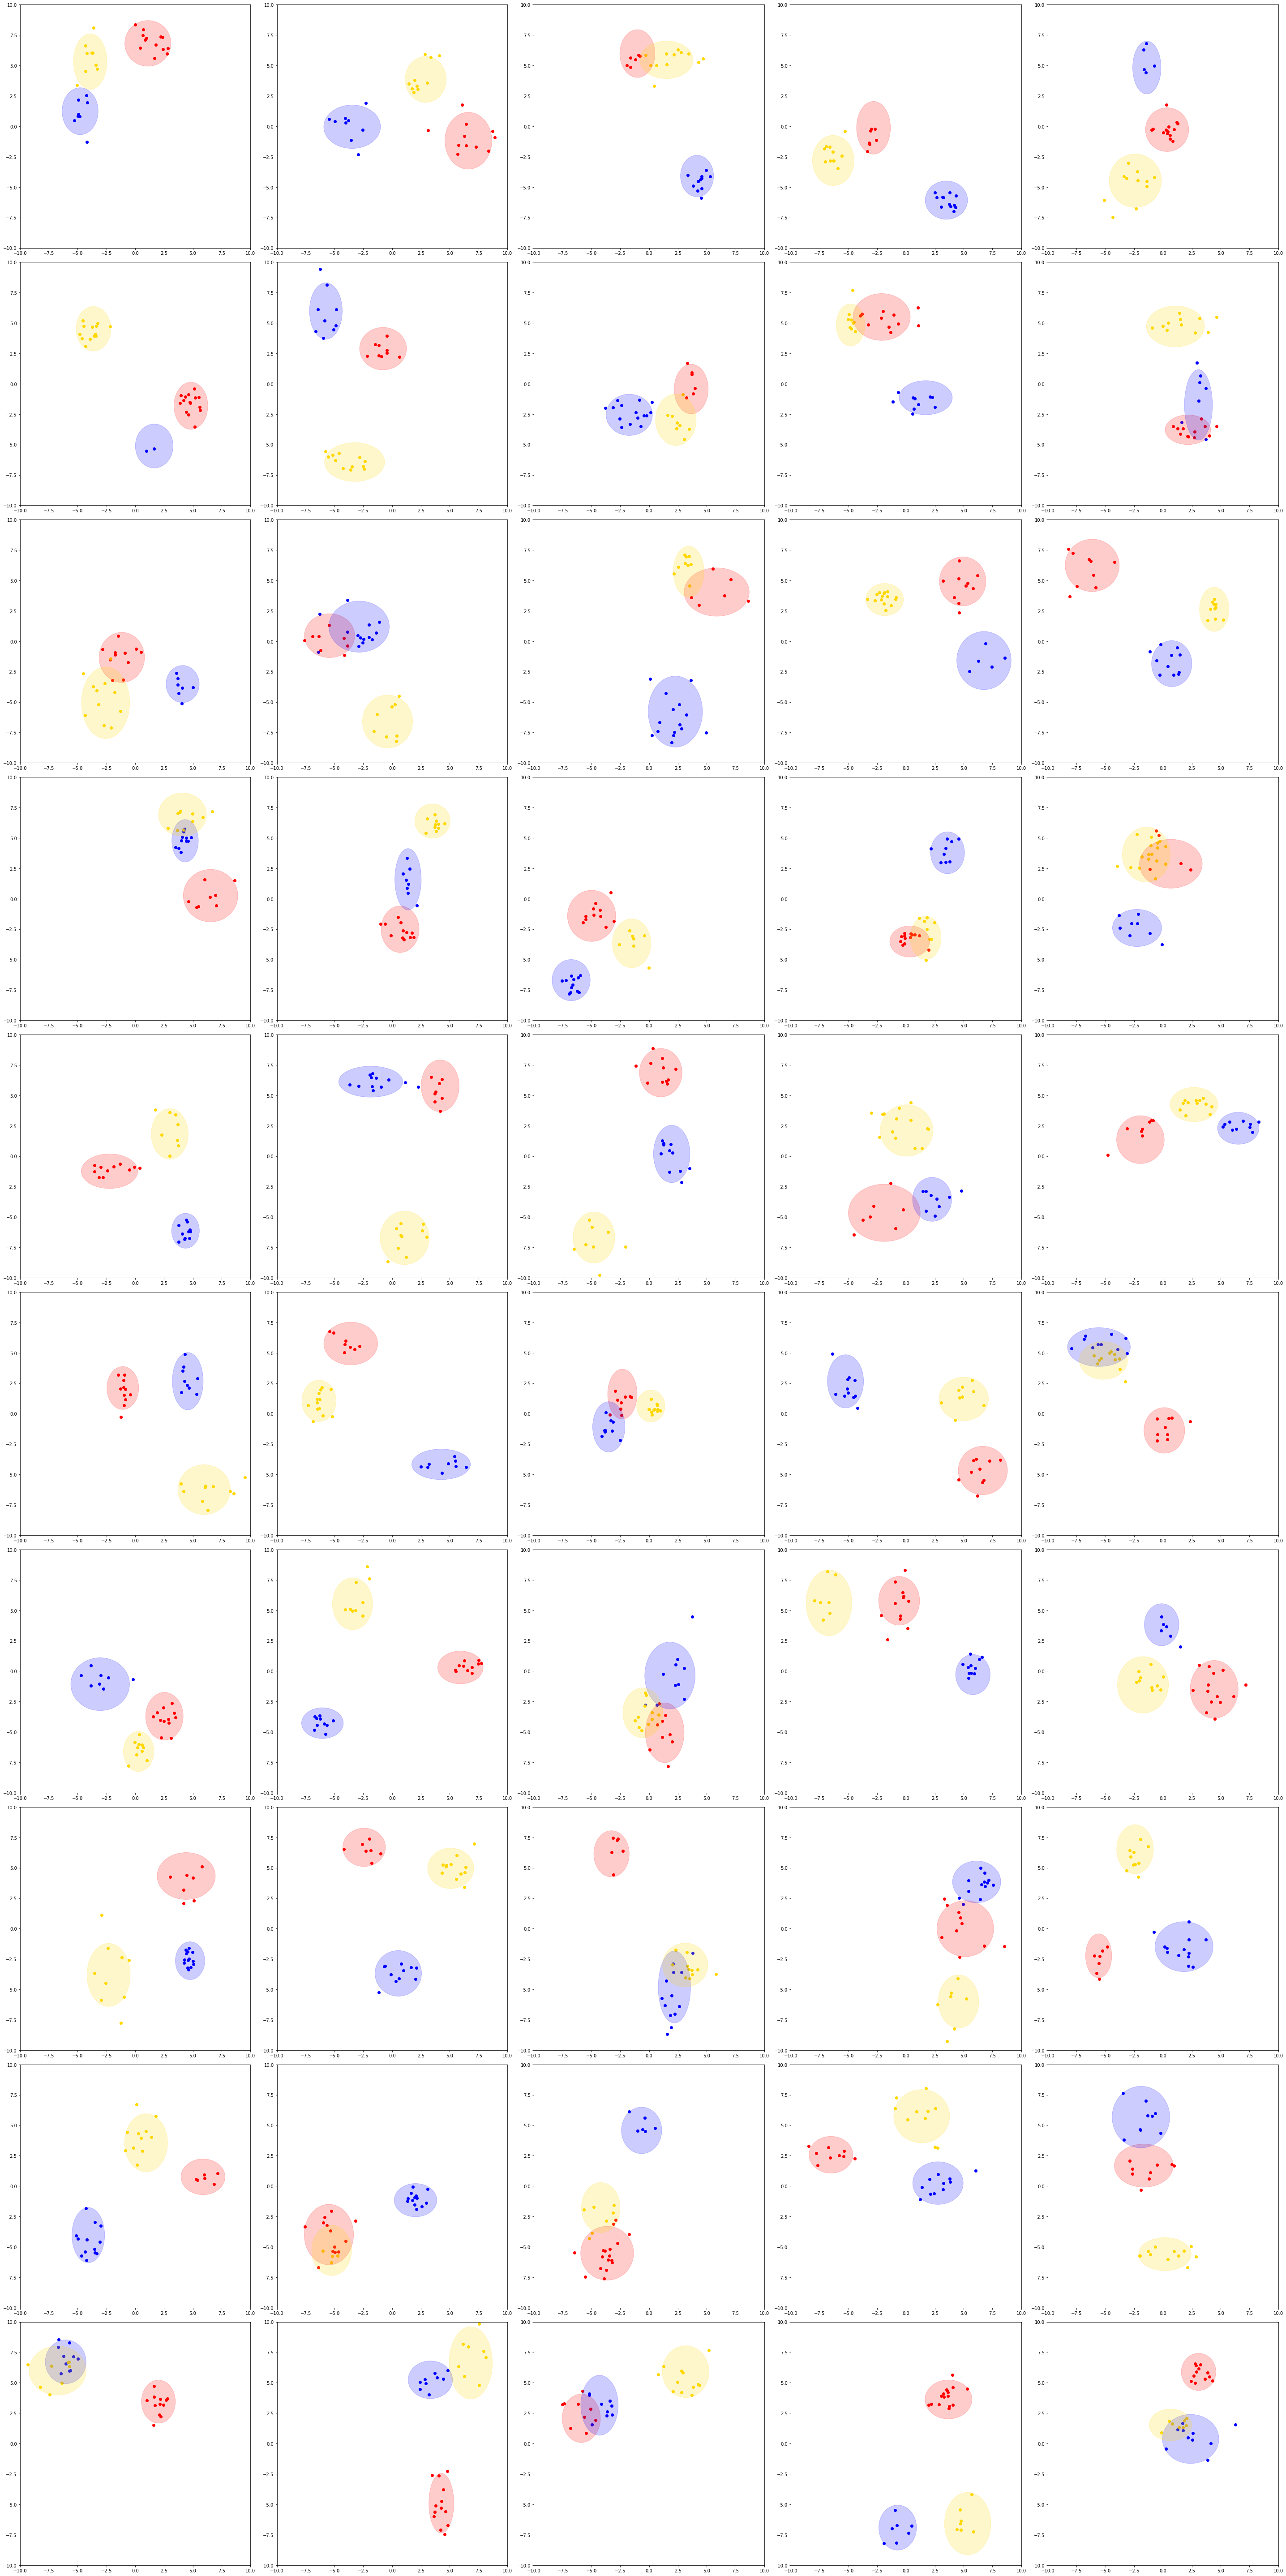

In [12]:
plot_predictions(batch_Xs, zs[0], batch_Mus, batch_Covs, BATCH_SIZE)

In [ ]:
torch.save(enc.state_dict(), 'models/enc-OneShotEncoder-only-learn-mus-samples=10-iters=1e6-lr=1e-4')

In [ ]:
def save_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE):
    fout = open('expand_OneShotEncoder_only_learn_mus_samples=%d_epochs=%d_lr=%1e-4.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) + ', ' + str(MCKls_exclusive[i]) + ', ' + str(TrueKls_exclusive[i]) + ', ' + str(MCKls_inclusive[i]) + ', ' + str(TrueKls_inclusive[i]) + '\n')
    fout.close()

In [ ]:
save_results(EUBOs, ELBOs, ESSs, MCKls_exclusive, TrueKls_exclusive, MCKls_inclusive, TrueKls_inclusive, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [ ]:
batch_Covs.shape